# Lab : Kaggle Credit card fraud detection

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

**Objectives:** Compare Logistic Regression classifiers on skewed data. The idea is to compare if preprocessing techniques work better when there is an overwhelming majority class that can disrupt the efficiency of the predictive model. Learn how to apply cross validation (CV) for hyper-parameter tuning.

In [45]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.filterwarnings('ignore',category=Warning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Load the anonimised dataset

Dataset contains only numerical input variables which are the result of a PCA (Principal Component Analysis) transformation. Due to confidentiality issues, the original features and more background information about the data cannot be provided. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. 
 
The last column is the Class:  normal transaction (0),  fraud transaction (1). 

Load the dataset stored in the file *"creditcard.csv"*. 

In [46]:
data = pd.read_csv("creditcard.csv")

# Confirm that the dimension of the data set is (284807, 31)    
print(data.shape)

#Compute the mean of each column, and observe that the anonimised features V1-V28 
#have mean arround 0
print(np.mean(data, axis=0))

# show the first few examples (rows) from the dataset 
data.head()

(284807, 31)
Time      9.481386e+04
V1        1.759061e-12
V2       -8.251130e-13
V3       -9.654937e-13
V4        8.321385e-13
V5        1.649999e-13
V6        4.248366e-13
V7       -3.054600e-13
V8        8.777971e-14
V9       -1.179749e-12
V10       7.092545e-13
V11       1.874948e-12
V12       1.053347e-12
V13       7.127611e-13
V14      -1.474791e-13
V15      -5.231558e-13
V16      -2.282250e-13
V17      -6.425436e-13
V18       4.950748e-13
V19       7.057397e-13
V20       1.766111e-12
V21      -3.405756e-13
V22      -5.723197e-13
V23      -9.725856e-13
V24       1.464150e-12
V25      -6.987102e-13
V26      -5.617874e-13
V27       3.332082e-12
V28      -3.518874e-12
Amount    8.834962e+01
Class     1.727486e-03
dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Normalize the values of Column Amount  

In [47]:
from sklearn.preprocessing import StandardScaler
#x.reshape(-1, 1) does not mean normalizing between -1,1). 
#It means collumn vector (-1 is all rows), second dymension is 1.

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

#drop column Time as irrelevant feature
#drop columnt Amount as column normAmount was added
data = data.drop(['Time','Amount'],axis=1)  

# show again the first few examples (rows) from the normalized dataset 
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


#### Compute the number of samples per class


In [48]:
number_records_fraud = len(data[data.Class == 1])

number_records_normal = len(data[data.Class == 0])

print('Class 1 ( fraud transaction):', number_records_fraud)  # ANSWER: Class 1 ( fraud transaction): 492

print('Class 0 (normal transaction) :', number_records_normal) # ANSWER: Class 0 (normal transaction) : 284315

Class 1 ( fraud transaction): 492
Class 0 (normal transaction) : 284315


###  Data is totally unbalanced ! How to approach this classification problem:

- Collect more data.  Nice strategy but not applicable in this case. 
- Change the performance metric (do not rely only on the Accuracy): compute Precision, Recall, F1_score.
- Resampling the dataset to have an approximate 50-50 ratio:
    - By OVER-sampling => add copies of the under-represented class.
    - By UNDER-sampling => delete instances from the over-represented class.
   

First, extract the features in matrix X and the class labels in vector y

In [49]:
X = data.iloc[:, data.columns != 'Class']
y = data["Class"]


In [50]:
X.shape

(284807, 29)

####  UNDER-sampling 

Apply UNDER-sampling by randomly selecting x samples from the majority class (0), where x is the total number of records with the minority class (1). 

The under-sampled dataset has a 50/50 class ratio of samples. 

In [51]:
# Picking the indices of the minority (fraud) class
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal class
normal_indices = np.array(data[data.Class == 0].index)

# Number of data points in the minority (fraud) class
number_records_fraud = len(fraud_indices)


# Out of the normal class indices, randomly select number_records_fraud samples 
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)


# Appending the indices of normal and fraud classes
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices,:]

# Balanced under-sampled Data 

print("Total # of transactions in resampled data:", len(under_sample_data)) #ANSWER:  984

print(" # of normal under sample transactions: ", len(under_sample_data[under_sample_data.Class == 0]))  #ANSWER:  492
print(" # of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 0]))                #ANSWER:  492

#The features in matrix X_undersample, the class labels in vector  y_undersample
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data["Class"]


Total # of transactions in resampled data: 984
 # of normal under sample transactions:  492
 # of fraud transactions:  492


### Explanation of random_state

All computers have what is called a pseudo-random number generator. This is something that produces seemingly random numbers, but if kept being repeated, would reproduce the same sequence eventually.
Where the number generator is started is known as the seed. When you specify the random_state parameter, you are just setting the random seed for the random number generator.

Suppose you set random_seed = 0. The random number generator might then produce the sequence of integers
0, 19, 11, 2, 34, 5, 23, 24, 0, 1, 89, …

and by fixing random_state=0, you will always see this sequence each time you call your train_test_split function. 

On the other hand, suppose you set random_state=1 and got the following sequence of integers:
91, 18, 11, 34, 34, 5, 19, 18, 0, 0, 1, …

You will always see these random numbers when you set random_state = 1. 

### Train-test data splitting

Apply *train_test_split* to the Whole dataset and to the Undersampled dataset with 30% train-test data ratio and random_state = 0. 

In [52]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(y_train))   #ANSWER: 199364
print("Number transactions test dataset: ", len(y_test))    #ANSWER:   85443
print("Total number of transactions: ", len(y))        #ANSWER:  284807

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size = 0.3, random_state = 0)

print() 
print("UNDER-SAMPLED DATA:")
print("Number transactions train dataset : ", len(y_train_undersample))  #ANSWER:  688

print("Number transactions test dataset: ", len(y_test_undersample))    #ANSWER:  296
print("Total number of transactions: ", len(y_undersample))        #ANSWER:  984


Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

UNDER-SAMPLED DATA:
Number transactions train dataset :  688
Number transactions test dataset:  296
Total number of transactions:  984


###  MODEL 1: Logistic regression classifier - Undersampled data

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

**Our goal is, do not miss a fraud transaction**, therefore  we are interested in the Recall score, because that is the metric to capture the most fraudulent transactions. Due to the imbalacing of the data, many observations could be predicted as False Negatives, that is, we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.

Precision is less important metric for this problem, because if we predict that a transaction is fraudulent but it is not (this is false positive case), this is not a massive problem compared to the opposite. 

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

### K-fold Cross Validation (CV) to find the best hyper-parameter C of Logistic Regression.  

C =1/$\lambda$, where $\lambda$ is the regularization parameter. 

In [54]:
# Find the best hyper-parameter C. Optimizing for recall perf. metric 
def print_gridsearch_scores(x_train_data,y_train_data):
    c_param_range = [0.01,0.1,1,10]

    clf = GridSearchCV(LogisticRegression(), {"C": c_param_range}, cv=5, scoring='recall')
    clf.fit(x_train_data,y_train_data)

    print("Best parameters found on CV(dev) set:")
    print()
    print(clf.best_params_)

    print("K-fold Score (Recall) on CV (dev) set:")
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    
    #Visualization of the K-fold Recall results for different hyper parameters C
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    return clf.best_params_["C"]

In [55]:
#Apply function print_gridsearch_scores to get the best C with the Undersampled dataset
best_c = print_gridsearch_scores(X_train_undersample, y_train_undersample)

Best parameters found on CV(dev) set:

{'C': 10}
K-fold Score (Recall) on CV (dev) set:
0.875 (+/-0.075) for {'C': 0.01}
0.896 (+/-0.087) for {'C': 0.1}
0.904 (+/-0.075) for {'C': 1}
0.913 (+/-0.078) for {'C': 10}


### Model 1.1: Logistic Regression trained and tested with undersampled data


In [56]:
# Use the best C to train LogReg model with undersampled train data and test it with undersampled test data
lr = LogisticRegression(C = best_c)
lr.fit(X_train_undersample,y_train_undersample)
y_pred_undersample = lr.predict(X_test_undersample)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

print('Confusion matrix (undersample test dataset)')
print(cnf_matrix)

#Compute Recall metric
print("Recall: ", recall_score(y_test_undersample, y_pred_undersample)) 

Confusion matrix (undersample test dataset)
[[148   1]
 [ 10 137]]
Recall:  0.9319727891156463



### Model 1.2: Logistic Regression trained on under-sampled data and tested with the whole test data

Apply the same approach as above. 


In [57]:
# Use the best C to train LogReg model with undersampled train dataset and test it with whole test dataset

lr = LogisticRegression(C = best_c)

#train on undersampled data
lr.fit(X_train_undersample,y_train_undersample)

#predict whole test data 
y_pred = lr.predict(X_test)

# Compute and print confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

print('Confusion matrix (undersample test dataset)')
print(cnf_matrix)


# Compute and print Recall metric
print("Recall: ", recall_score(y_test, y_pred)) 


Confusion matrix (undersample test dataset)
[[82588  2708]
 [   10   137]]
Recall:  0.9319727891156463


###  ROC curve & AUC

Plot the Receiver Operating Characteristic (ROC) curve and compute the Area Under the ROC Curve (AUC). 


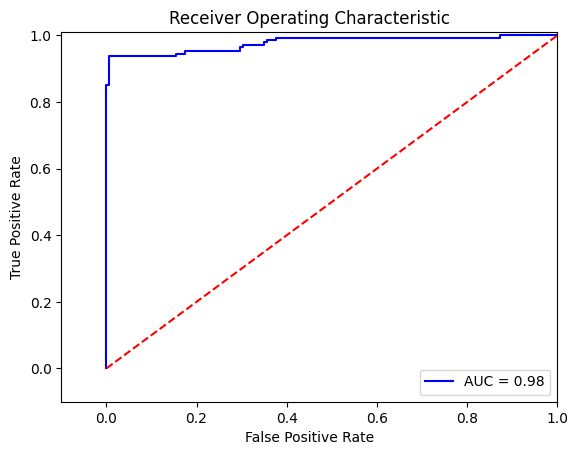

In [58]:
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train_undersample,y_train_undersample)
y_pred_undersample_score=lr.decision_function(X_test_undersample)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_undersample,y_pred_undersample_score)

# Compute Area Under the ROC Curve (AUC), it is a scalar 
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REMARK
To create the undersampled data, we randomly picked some samples from the majority class. This is a valid technique, however is doesn't represent the real (huge) population. 
For sufficient statistical credibility, it would be usefull to repeat the process with different undersampled configurations and check if the previous chosen parameters are still the most effective. In the end, the idea is to use a wider random representation of the whole dataset and rely on the averaged best parameters.

### MODEL 2: Logistic regression classifier - Skewed data

Now, apply K-fold Cross Validation (CV) to find the best hyper-parameter C with whole train data, as it was done above. 

K-fold is now computationally much more time consuming. 

In [61]:
#Apply function print_gridsearch_scores to get the best C with the Undersampled dataset
best_c = print_gridsearch_scores(X_train, y_train)

Best parameters found on CV(dev) set:

{'C': 10}
K-fold Score (Recall) on CV (dev) set:
0.580 (+/-0.112) for {'C': 0.01}
0.609 (+/-0.108) for {'C': 0.1}
0.617 (+/-0.114) for {'C': 1}
0.620 (+/-0.122) for {'C': 10}


Use the best C to train LogReg model with the whole train data and test it with whole test data. 


In [64]:
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Compute and print confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)

print('Confusion matrix')
print(cnf_matrix)


# Compute and print Recall metric
print("Recall: ", recall_score(y_test, y_pred)) 


Confusion matrix
[[85284    12]
 [   56    91]]
Recall:  0.6190476190476191
